(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [107]:
# Import project package
import Antibiotic

# Import project package
import AutoEncode

# Import libraries to handel data
import CSV
import DataFrames as DF
import Glob

# Import ML libraries
import Flux

# Import library to save models
import JLD2

# Import basic math
import StatsBase
import Random
Random.seed!(42)

# Import Plotting libraries
using CairoMakie
import ColorSchemes

# Activate backend
CairoMakie.activate!()

# Set Plotting style
Antibiotic.viz.theme_makie!()

# Exploratory data analysis of the $\beta$-RHVAE results

`[explanation here]`

Let's begin by listing the files with the saved model.

In [108]:
# List files in output directory
files = Glob.glob("output/model_state/*.jld2")

first(files, 5)

5-element Vector{String}:
 "output/model_state/beta-rhvae_pre1_epoch00001.jld2"
 "output/model_state/beta-rhvae_pre1_epoch00002.jld2"
 "output/model_state/beta-rhvae_pre1_epoch00003.jld2"
 "output/model_state/beta-rhvae_pre1_epoch00004.jld2"
 "output/model_state/beta-rhvae_pre1_epoch00005.jld2"

Now, let's loop through each file, and load the values of the loss function and
the mean squared error for each model.

In [109]:
# Initialize empty dataframe
df_train = DF.DataFrame()
# Define fields to keep
fields = ["mse_train", "mse_val", "loss_train", "loss_val"]

# Loop through files
for f in files
    # spit file name to extract beta value and epoch number
    pars = split(f, "_")[end-1:end]
    # Parse beta value
    pre = parse(Float64, replace(pars[1], "pre" => ""))
    # Parse epoch number
    epoch = parse(Int, replace(pars[2], ".jld2" => "", "epoch" => ""))
    # Load file and keep relevant fields
    file_load = JLD2.load(f)
    # Convert to dataframe
    df_tmp = DF.DataFrame(Dict(zip(fields, [file_load[x] for x in fields])))
    # Add beta and epoch to dataframe
    df_tmp[!, :pre] .= pre
    df_tmp[!, :epoch] .= epoch

    # Append to main dataframe
    DF.append!(df_train, df_tmp)
end # for

# Sort by beta and epoch
DF.sort!(df_train, [:pre, :epoch])

first(df_train, 5)

Row,loss_train,loss_val,mse_train,mse_val,pre,epoch
,Float32,Float32,Float32,Float32,Float64,Int64
1,110.146,112.199,0.93689,0.986057,1.0,1
2,104.995,106.334,0.774606,0.818173,1.0,2
3,100.983,101.639,0.635706,0.64361,1.0,3
4,98.7891,99.7864,0.59189,0.612931,1.0,4
5,96.5816,97.6317,0.545797,0.557701,1.0,5


With this information we can then plot the loss function and the mean squared
error for each model.

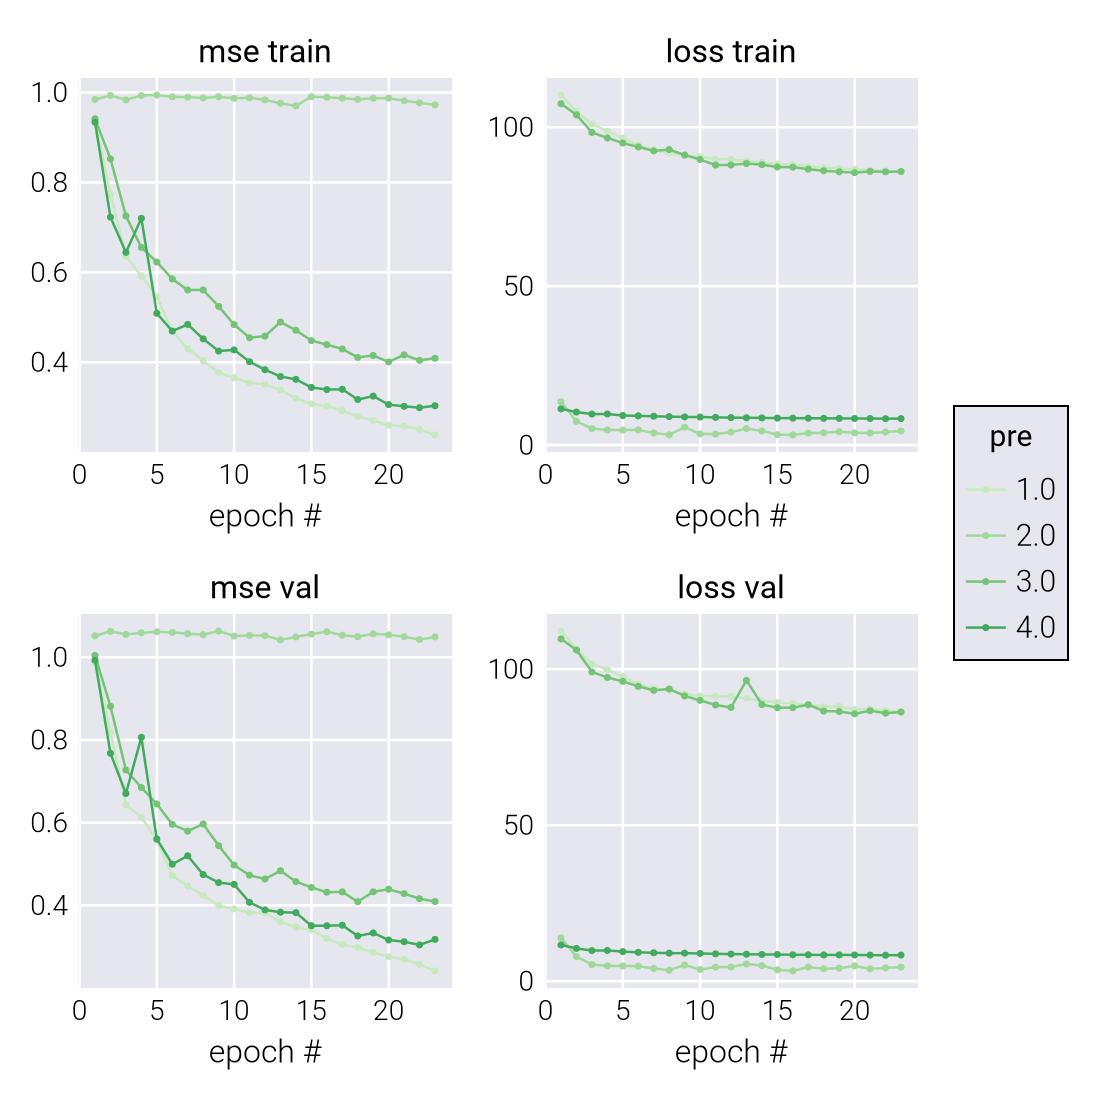

In [110]:
# Group data by β value
df_group = DF.groupby(df_train, :pre)

# Initialize figure
fig = Figure(size=(550, 550))

# Add axes to figure
axes = [
    Axis(
        fig[i, j],
        aspect=AxisAspect(1),
        xlabel="epoch #",
    ) for i in 1:2, j in 1:2
]

# Loop through fields
for (i, field) in enumerate(fields)
    # Get axis
    ax = axes[i]
    # Loop through groups
    for (j, df) in enumerate(df_group)
        # Get x and y values
        x = df.epoch
        y = df[:, field]
        # Plot
        scatterlines!(
            ax, x, y, color=ColorSchemes.Greens[j+2], markersize=5,
            label="$(df.pre[1])"
        )
    end # for
    # Set subplot title
    ax.title = replace(field, "_" => " ")
end # for

# Add legend to first subplot
Legend(fig[1:2, 3], axes[1], "pre", position=:rt)

fig

## Mapping points to latent space

The model with $\beta = 0.01$ seems to be generalizing the best. Let's use this
model to map the points to the latent space and see if we can find any
interesting structure.

In [111]:
# List files in output directory
model_files = sort(Glob.glob("output/model_state/*pre1*.jld2"))

# Load model
rhvae = JLD2.load("output/model.jld2")["model"]

# Load parameters
model_state = JLD2.load(model_files[end])["model_state"]

# Set model parameters
Flux.loadmodel!(rhvae, model_state)

# Update metric
AutoEncode.RHVAEs.update_metric!(rhvae)

typeof(vae)

AutoEncode.RHVAEs.RHVAE{AutoEncode.VAEs.VAE{AutoEncode.JointLogEncoder, AutoEncode.SimpleDecoder}}

Let's load the data.

In [112]:
# Define data directory
data_dir = "$(git_root())/data/Iwasawa_2022"

# Load file into memory
df_ic50 = CSV.read("$(data_dir)/iwasawa_ic50_tidy.csv", DF.DataFrame)

# Locate strains with missing values
missing_strains = unique(df_ic50[ismissing.(df_ic50.log2ic50), :strain])

# Remove data
df_ic50 = df_ic50[[x ∉ missing_strains for x in df_ic50.strain], :]

# Group data by strain and day
df_group = DF.groupby(df_ic50, [:strain, :day])

# Extract unique drugs to make sure the matrix is built correctly
drug = sort(unique(df_ic50.drug))

# Initialize matrix to save ic50 values
ic50_mat = Matrix{Float32}(undef, length(drug), length(df_group))

# Loop through groups
for (i, data) in enumerate(df_group)
    # Sort data by stress
    DF.sort!(data, :drug)
    # Check that the stress are in the correct order
    if all(data.drug .== drug)
        # Add data to matrix
        ic50_mat[:, i] = Float32.(data.log2ic50)
    else
        println("group $i stress does not match")
    end # if
end # for

# Define number of environments
n_env = size(ic50_mat, 1)
# Define number of samples
n_samples = size(ic50_mat, 2)

# Fit model to standardize data to mean zero and standard deviation 1 on each
# environment
dt = StatsBase.fit(StatsBase.ZScoreTransform, ic50_mat, dims=2)

# Center data to have mean zero and standard deviation one
ic50_std = StatsBase.transform(dt, ic50_mat)

8×1269 Matrix{Float32}:
 -0.549695  -0.636041  -0.645549  …  -0.52737   -0.567254  -0.489156
  0.127085   0.396026   0.422921      0.152449   0.106901   0.0836802
 -0.952641  -0.814063  -0.947413     -0.712676  -0.723125  -0.706011
  0.434811  -0.480968  -0.244397      0.702219   0.484944   0.544966
 -0.469319  -0.463574  -0.461562     -0.450975  -0.278867  -0.296857
  0.689883   0.638487   0.126388  …   0.910045   0.774161   0.968758
  0.22606    0.13382    0.396659     -0.436597  -0.589569  -0.649776
 -0.605906  -0.748028  -0.533354     -0.860089  -1.17661   -0.934113

Now, let's encode the data using the model encoder to obtain the latent space
representation of the data.

In [113]:
# Encode data to latent space
latent_train = rhvae.vae.encoder(ic50_std).µ

2×1269 Matrix{Float32}:
 0.737557  0.502907  0.357575  -0.178584  …  0.826388  0.737758  0.771274
 0.904851  0.629993  0.627426  -0.104791     0.964126  0.871321  0.799098

Let's plot the latent space representation of the data.

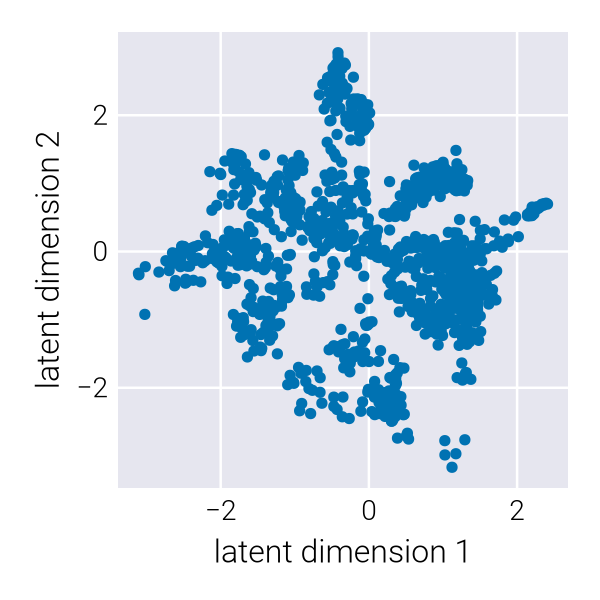

In [114]:
# Initialize plot
fig = Figure(size=(300, 300))

# Add axis to plot
ax = Axis(
    fig[1, 1],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
)

# Add scatter plot to axis
scatter!(
    ax,
    latent_train[1, :],
    latent_train[2, :],
    markersize=8,
)

fig

There is some interesting structure with isolated clusters of points. But,
without a metric or a decoder uncertainty, the interpolation between points is
not very informative.

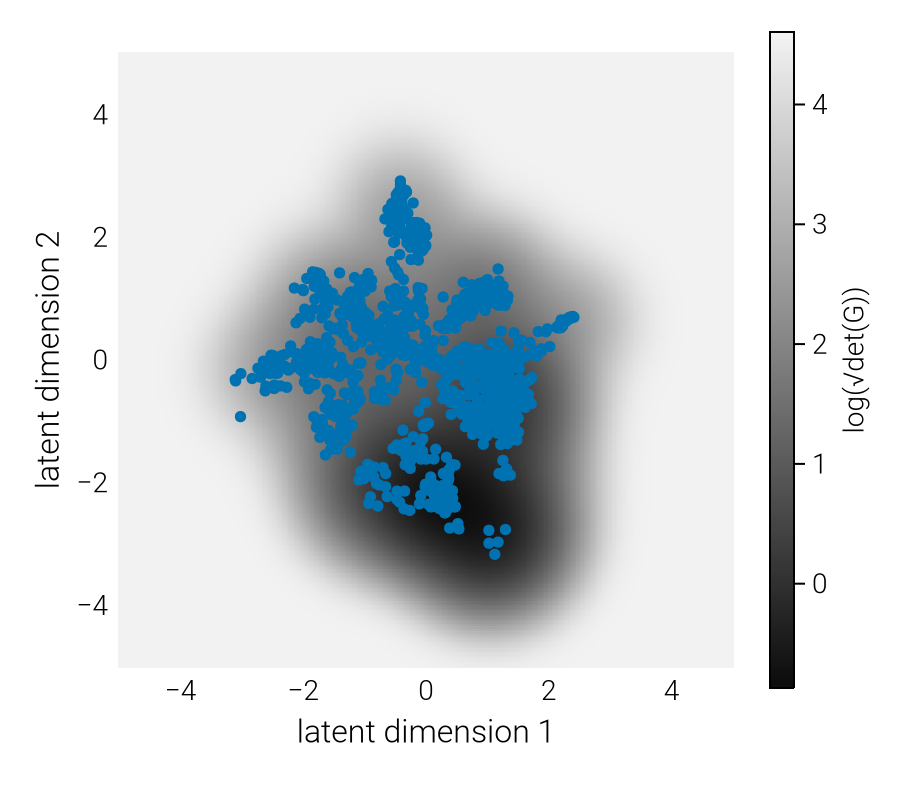

In [115]:
# Define number of points per axis
n_points = 250

# Define range of latent space
latent_range = Float32.(range(-5, 5, length=n_points))

# Define latent points to evaluate
z_mat = reduce(hcat, [[x, y] for x in latent_range, y in latent_range])

# Compute inverse metric tensor
Ginv = AutoEncode.RHVAEs.G_inv(z_mat, rhvae)

# Compute log determinant of metric tensor
logdetG = reshape(-1 / 2 * AutoEncode.utils.slogdet(Ginv), n_points, n_points)

# Initialize figure
fig = Figure(size=(450, 400))

# Add axis to figure
ax = Axis(
    fig[1, 1],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    aspect=AxisAspect(1)
)

# Plot heatmap of log determinant of metric tensor
hm = heatmap!(ax, latent_range, latent_range, logdetG, colormap=:grays)

# Add colorbar to figure
fig[1, 2] = Colorbar(fig, hm, label="log(√det(G))")

# Add scatter plot to axis
scatter!(
    ax,
    latent_train[1, :],
    latent_train[2, :],
    markersize=8,
)

fig

Let's extract these latent space representations and append the corresponding
metadata.

In [116]:
# Extract strains as ordered in ic50 matrix
strains_mat = [x.strain for x in keys(df_group)]
day_mat = [x.day for x in keys(df_group)]

# Generate dataframe with corresponding metadata
df_meta_mat = DF.DataFrame(
    strain=strains_mat,
    day=day_mat,
    z1=latent_train[1, :],
    z2=latent_train[2, :],
)

# Add corresponding metadata resistance value
df_meta_mat = DF.leftjoin!(
    df_meta_mat,
    unique(df_ic50[:, [:strain, :day, :parent, :env]]),
    on=[:strain, :day]
)

first(df_meta_mat, 5)

Row,strain,day,z1,z2,parent,env
,String31,Int64,Float32,Float32,String7,String7
1,Parent in TET 1,1,0.737557,0.904851,Parent,TET
2,Parent in TET 1,2,0.502907,0.629993,Parent,TET
3,Parent in TET 1,3,0.357575,0.627426,Parent,TET
4,Parent in TET 1,4,-0.178584,-0.104791,Parent,TET
5,Parent in TET 1,5,-0.221076,0.244098,Parent,TET


We can now repeat the same plot as above, but this time coloring each point by
their strain.

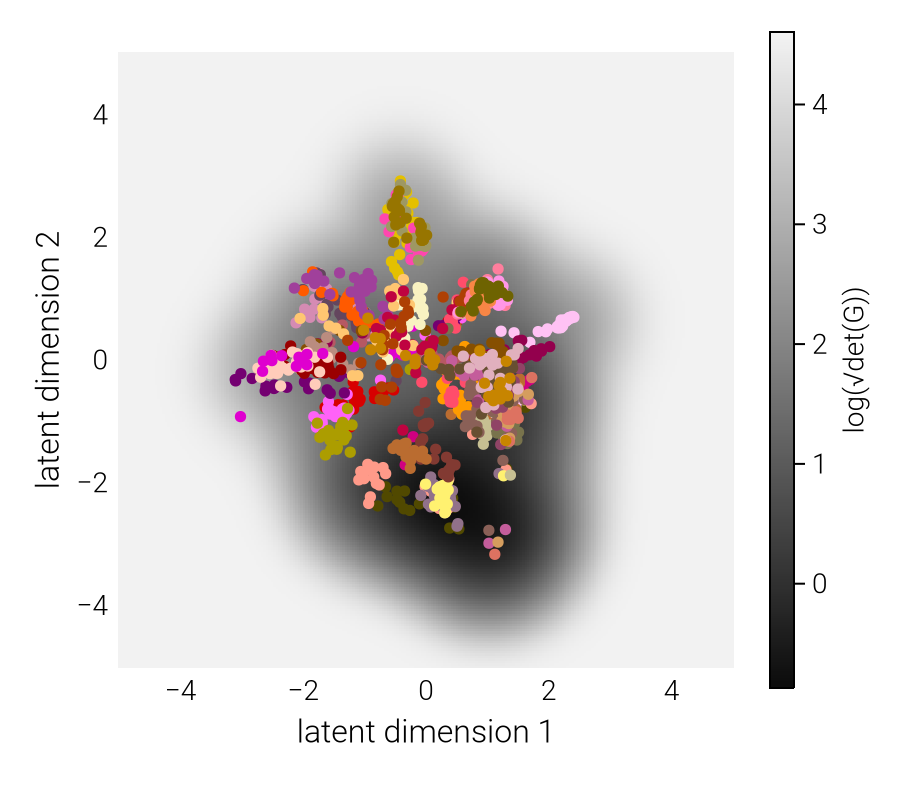

In [117]:
# Initialize figure
fig = Figure(size=(450, 400))

# Add axis to figure
ax = Axis(
    fig[1, 1],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    aspect=AxisAspect(1)
)

# Plot heatmap of log determinant of metric tensor
hm = heatmap!(ax, latent_range, latent_range, logdetG, colormap=:grays)

# Add colorbar to figure
fig[1, 2] = Colorbar(fig, hm, label="log(√det(G))")

# Group data by resistance
df_group = DF.groupby(df_meta_mat, :strain)

# Loop through groups
for (i, data) in enumerate(df_group)
    # Add scatter plot to axis
    scatter!(
        ax,
        data.z1,
        data.z2,
        markersize=8,
        label=data.strain[1],
        color=ColorSchemes.glasbey_bw_minc_20_hue_330_100_n256[i],
    )
end

fig

Let's repeat this process but this time coloring the points by the environment
(antibiotic) in which they evolved.

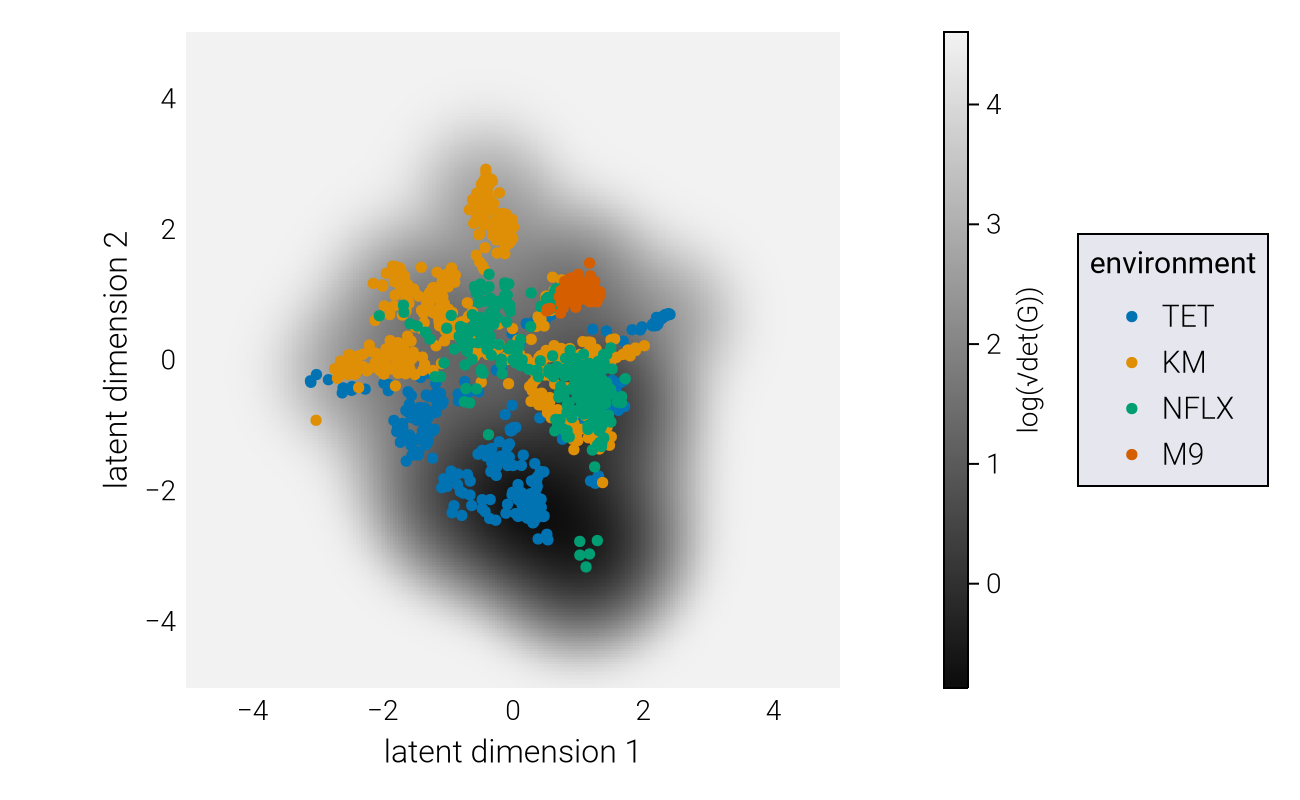

In [118]:
# Initialize figure
fig = Figure(size=(650, 400))

# Add axis to figure
ax = Axis(
    fig[1, 1],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    aspect=AxisAspect(1)
)

# Plot heatmap of log determinant of metric tensor
hm = heatmap!(ax, latent_range, latent_range, logdetG, colormap=:grays)

# Add colorbar to figure
fig[1, 2] = Colorbar(fig, hm, label="log(√det(G))")

# Group data by resistance
df_group = DF.groupby(df_meta_mat, :env)

# Loop through groups
for (i, data) in enumerate(df_group)
    # Add scatter plot to axis
    scatter!(
        ax,
        data.z1,
        data.z2,
        markersize=8,
        label=data.env[1],
        color=ColorSchemes.seaborn_colorblind[i],
    )
end

# Add legend to axis
fig[1, 3] = Legend(fig, ax, "environment")

fig

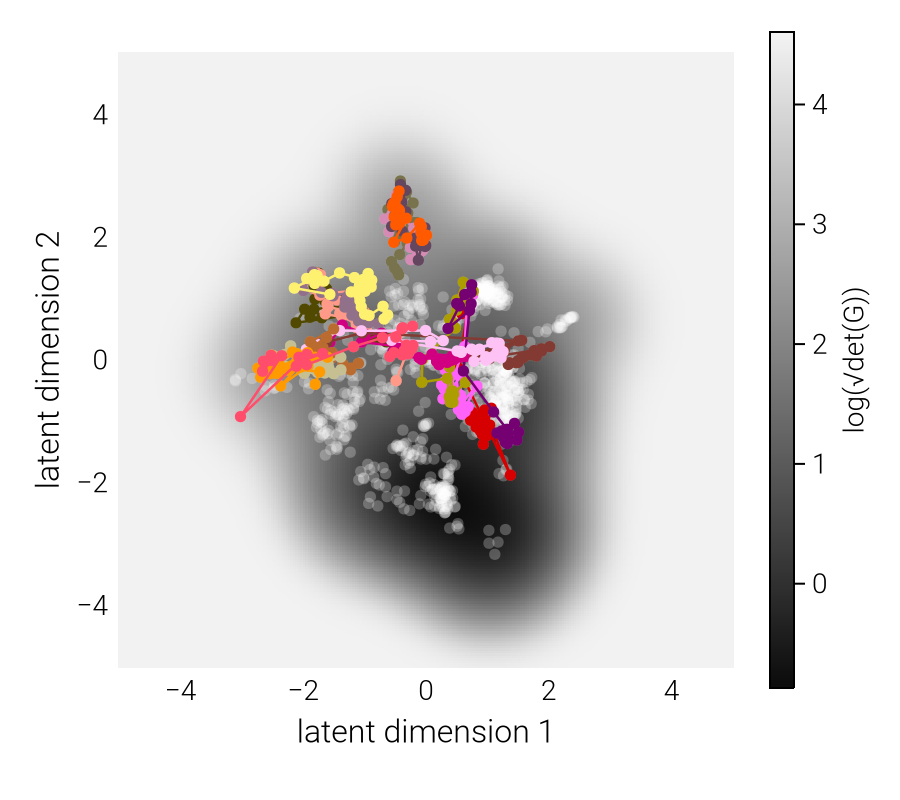

In [119]:
# Initialize figure
fig = Figure(size=(450, 400))

# Add axis to figure
ax = Axis(
    fig[1, 1],
    xlabel="latent dimension 1",
    ylabel="latent dimension 2",
    aspect=AxisAspect(1)
)

# Plot heatmap of log determinant of metric tensor
hm = heatmap!(ax, latent_range, latent_range, logdetG, colormap=:grays)

# Add colorbar to figure
fig[1, 2] = Colorbar(fig, hm, label="log(√det(G))")

# Add scatter plot to axis
scatter!(
    ax,
    df_meta_mat.z1,
    df_meta_mat.z2,
    markersize=8,
    color=(:white, 0.25),
)

# Group data by resistance
df_group = DF.groupby(df_meta_mat[df_meta_mat.env.=="KM", :], :strain)

# # Loop through groups
for (i, data) in enumerate(df_group)
    # Order data by day
    DF.sort!(data, :day)

    # Add scatter plot to axis
    scatterlines!(
        ax,
        data.z1,
        data.z2,
        markersize=8,
        color=ColorSchemes.glasbey_bw_minc_20_hue_330_100_n256[i],
    )
end

fig